# Ch. 5 - Classification

# Student Performance – Classification (Chapter 5)

In this notebook I build and compare several classification models on the
*StudentsPerformance* dataset. The goal is to predict:

- **pass_math** – whether a student passes math (score ≥ 60)
- **top_math** – whether a student is in the top 10% of math scores (rare class)

Earlier notebooks cover EDA and regression; here I focus on classification:
Naive Bayes, Linear Discriminant Analysis (LDA), and Logistic Regression,
including imbalanced-class strategies.

## Setup and Feature Engineering

- Load the CSV
- One-hot encode `gender`
- Create `pass_math` and `top_math`
- Train/test split for `pass_math` and for `top_math`

In [2]:
# Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Get data set

df = pd.read_csv("C:/Users/keele/Downloads/archive/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
# Define target

# pass_math = 1 if math score >= 60, else 0

df['pass_math'] = (df['math score'] >= 60).astype(int)

df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,pass_math
0,female,group B,bachelor's degree,standard,none,72,72,74,1
1,female,group C,some college,standard,completed,69,90,88,1
2,female,group B,master's degree,standard,none,90,95,93,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,0
4,male,group C,some college,standard,none,76,78,75,1


In [5]:
# One-hot encode the gender category (1 for male, 0 for female)

df = pd.get_dummies(df, columns=['gender'], drop_first=True, dtype=int)
df.head()

,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,pass_math,gender_male
0,group B,bachelor's degree,standard,none,72,72,74,1,0
1,group C,some college,standard,completed,69,90,88,1,0
2,group B,master's degree,standard,none,90,95,93,1,0
3,group A,associate's degree,free/reduced,none,47,57,44,0,1
4,group C,some college,standard,none,76,78,75,1,1


In [6]:
# Sanity check

df['gender_male'].value_counts()

gender_male
0    518
1    482
Name: count, dtype: int64

In [7]:
# Create a rare-class target (top_math); top 10% of math scores

threshold = np.percentile(df['math score'], 90)
df['top_math'] = (df['math score'] >= threshold).astype(int)
df.head()

,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,pass_math,gender_male,top_math
0,group B,bachelor's degree,standard,none,72,72,74,1,0,0
1,group C,some college,standard,completed,69,90,88,1,0,0
2,group B,master's degree,standard,none,90,95,93,1,0,1
3,group A,associate's degree,free/reduced,none,47,57,44,0,1,0
4,group C,some college,standard,none,76,78,75,1,1,0


In [8]:
# top_math distribution check
df['top_math'].value_counts()

top_math
0    897
1    103
Name: count, dtype: int64

Now I will choose my features + train/test split

- input features will be reading score, writing score, gender
- my target variables will be pass_math for the main target, and the rare class target will be top_math
    - for now, y = pass_math

In [9]:
# Set up X and y and the train/test split; have the test size be 20%

X = df[['reading score', 'writing score', 'gender_male']]
y = df['pass_math']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Naive Bayes – pass/fail

Here I fit a Gaussian Naive Bayes model to predict `pass_math` using
`reading score`, `writing score`, and `gender_male`.
I evaluate it with accuracy, precision, recall, confusion matrix, and ROC/AUC.

### Naive Bayes

In [10]:
# Train a Naive Bayes Classifier
# Use GaussianNB since the input features are contiuous

naive_model = GaussianNB()
naive_model.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [11]:
# Use the test data now to see y_pred

y_pred_naive = naive_model.predict(X_test)

In [12]:
# Predicted probabilities

y_proba_naive = naive_model.predict_proba(X_test)[:, 1]

Accuracy: 0.83
Precision: 0.875
Recall: 0.8615384615384616


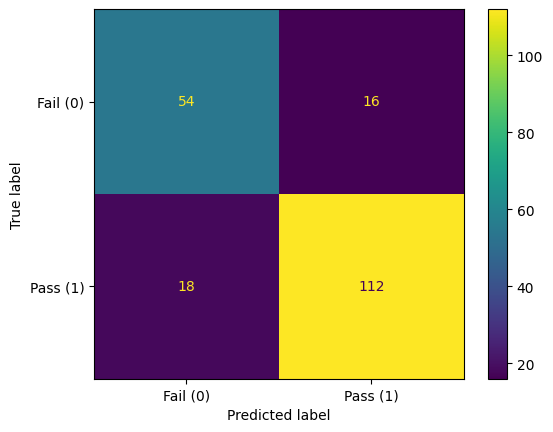

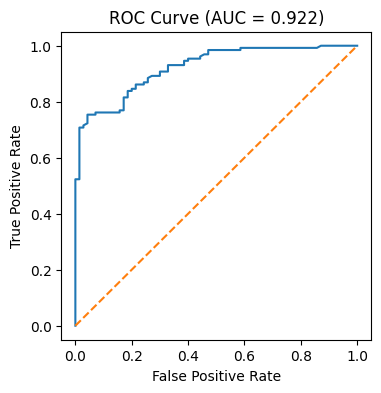

In [13]:
# Print metrics

# accuracy, precision, recall
print(f"Accuracy: {accuracy_score(y_test, y_pred_naive)}")
print(f"Precision: {precision_score(y_test, y_pred_naive)}")
print(f"Recall: {recall_score(y_test, y_pred_naive)}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred_naive)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail (0)', "Pass (1)"])
disp.plot()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_naive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

- Has an accuracy of 83%: correctly classifies 83% of students as pass/fail
- Has a precision of 0.875: When NB predicts PASS, it is correct about 87.5% of the time (low false positives)
- Has a recall of 0.861: NB catches about 86% of actual PASS students (not many false negatives)

- 16 false positives and 18 false negatives

- AUC of 0.922: If NB is given a pass and fail couple (1 pass 1 fail), it will pick pass correctly 92.2% of the time

## Linear Discriminant Analysis (LDA) – pass/fail

Next I fit an LDA classifier on the same features and compare its performance
to Naive Bayes.

### Linear Discriminant Analysis (LDA)

In [14]:
# LDA Classifier training with previous X_train and y_train

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [15]:
# Use the X_test data to see the new y_pred

y_pred_lda = lda_model.predict(X_test)

In [16]:
# Predicted probabilities

y_proba_lda = lda_model.predict_proba(X_test)[:, 1]

Accuracy: 0.88
Precision: 0.8785714285714286
Recall: 0.9461538461538461


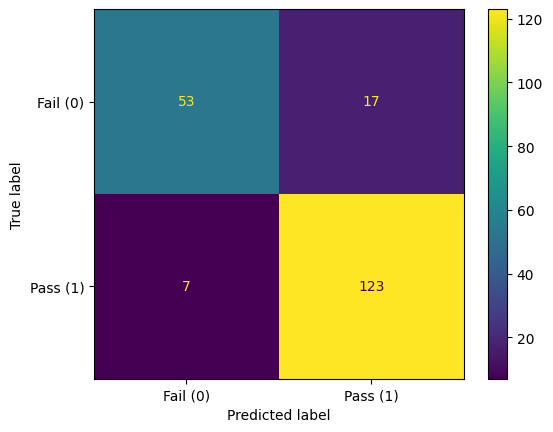

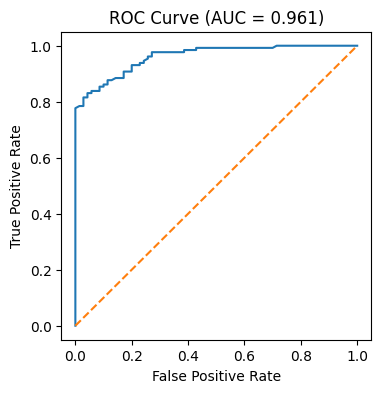

In [17]:
# Print metrics

# accuracy, precision, recall
print(f"Accuracy: {accuracy_score(y_test, y_pred_lda)}")
print(f"Precision: {precision_score(y_test, y_pred_lda)}")
print(f"Recall: {recall_score(y_test, y_pred_lda)}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail (0)', "Pass (1)"])
disp.plot()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

- Has an accuracy of 88%: correctly classifies 88% of students as pass/fail
- Has a precision of 0.879: When LDA predicts PASS, it is correct about 87.9% of the time (low false positives)
- Has a recall of 0.946: LDA catches about 94.6% of actual PASS students (not many false negatives)

- 17 false positives and 7 false negatives

- AUC of 0.961: If LDA is given a pass and fail couple (1 pass 1 fail), it will pick pass correctly 96.1% of the time

## Naive Bayes vs LDA
- Accuracy (LDA winner)
- Precision (LDA winner)
- Recall (LDA winner)
- AUC (LDA winner)

Interpretation: Linear Discriminant Analysis clearly outperforms Naive Bayes, and is the stronger classifier for this dataset.

***Why LDA Wins:***
- The main reason is feature correlation

- Reading score and writing score are strongly correlated.
- Naive Bayes assumes independence, so it struggles when features overlap.
- LDA models the covariance structure, so it handles correlated features correctly.

***Conclusion***
- LDA is the superior model for this dataset.

### Logistic Regression

In [18]:
# Logistic Regression Classifier using the previous X_train and y_train

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
# Use the X_test data to see the new y_pred

y_pred_lr = lr_model.predict(X_test)

In [20]:
# Get predicted probabilities

y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [21]:
# Get coefficient / intercept

print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_}")

Coefficients: [[0.08753942 0.17466044 3.59288657]]
Intercept: [-17.80786496]


In [22]:
# Convert Coefficients -> Odds Ratios

print(np.exp(lr_model.coef_))
print(np.exp(lr_model.intercept_))

[[ 1.09148529  1.19084178 36.33881906]]
[1.84562096e-08]


Accuracy: 0.88
Precision: 0.8785714285714286
Recall: 0.9461538461538461


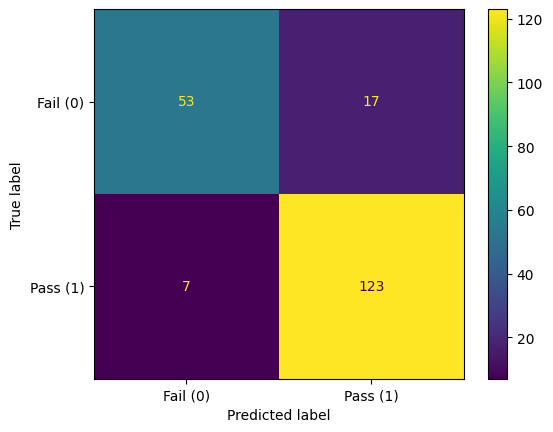

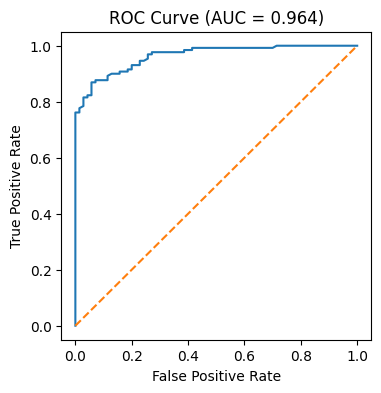

In [23]:
# Print metrics

# accuracy, precision, recall
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Precision: {precision_score(y_test, y_pred_lr)}")
print(f"Recall: {recall_score(y_test, y_pred_lr)}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail (0)', "Pass (1)"])
disp.plot()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

- Logistic Regression has the best AUC (slightly) with AUC = 0.964.
- Logistic Regression and LDA tie on accuracy, precision, and recall.
- Beats Naive Bayes significantly like LDA.
- All 3 models perform well.

- Reading odds ratio is 1.0915: For each additional 1 point in reading, the odds of passing math increase by about 9.15%
- Writing odds ratio is 1.1908: For each additional 1 point in writing, the odds of passing math increase by about 19.08%
- Gender odds ratio is 36.3388: Holding reading and writing constant, the odds of passing math are ~36x higher for male students compared to female students.

## ***Model Comparison Summary (Naive Bayes vs LDA vs Logistic Regression)***
Accuracy:
- LDA and Logistic Regression both achieve 88%, outperforming Naive Bayes (83%).

Precision (for predicting PASS):
- All three models are similar (0.875–0.879), meaning they are equally careful when predicting PASS.

Recall (ability to detect actual PASS students):
- Naive Bayes: 0.861
- LDA & Logistic Regression: 0.946

- LDA and Logistic Regression significantly reduce false negatives, correctly identifying many more PASS students.

AUC (probability the model ranks a PASS student higher than a FAIL student):
- Naive Bayes: 0.922
- LDA: 0.961
- Logistic Regression: 0.964 (best)

### ***Interpretation:***
Logistic Regression achieves the highest AUC, meaning it produces the best probability ranking. LDA is a close second. Naive Bayes performs well but is clearly weaker on recall and AUC because it assumes feature independence (not true here since reading/writing are correlated).

## Imbalanced Classification – top_math (top 10%)

Now I switch to the rare-class target `top_math` (top 10% math score).
This is heavily imbalanced, so accuracy alone is misleading.

***Imbalanced Classification***

In [24]:
# Look at how many students are labeled top_math =1

df['top_math'].value_counts()

top_math
0    897
1    103
Name: count, dtype: int64

In [25]:
# Fit the logistic regression model

# new y (y2)
y2 = df['top_math']

# train_test_split now with new target (y2)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X, y2, test_size = 0.2, random_state = 42)

# fit log reg model
top_math_lr_model = LogisticRegression()
top_math_lr_model.fit(X_train_top, y_train_top)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [26]:
# new y_pred

# predict
y_pred_top = top_math_lr_model.predict(X_test_top)

# predict probabilities
y_proba_top = top_math_lr_model.predict_proba(X_test_top)[:, 1]

Accuracy: 0.945
Precision: 0.5714285714285714
Recall: 0.6153846153846154


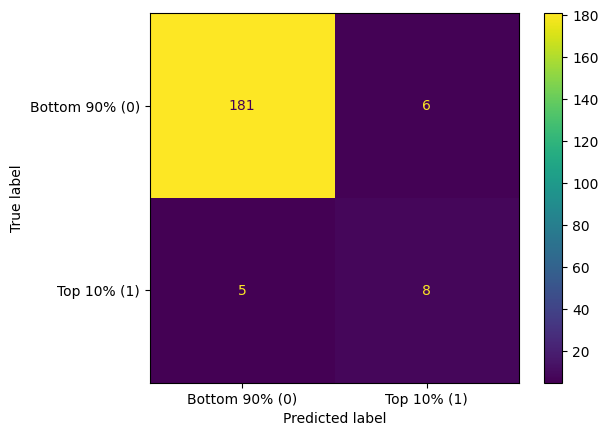

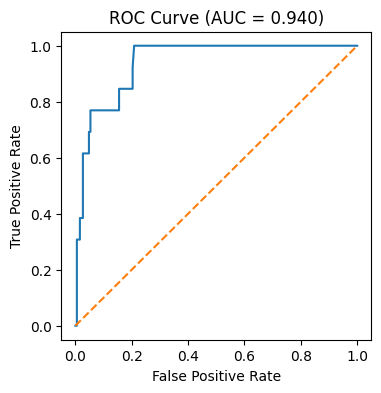

In [27]:
# Accuracy, Precision, Recall, AUC

print(f"Accuracy: {accuracy_score(y_test_top, y_pred_top)}")
print(f"Precision: {precision_score(y_test_top, y_pred_top)}")
print(f"Recall: {recall_score(y_test_top, y_pred_top)}")

# confusion matrix
cm_top = confusion_matrix(y_test_top, y_pred_top)
disp_top = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=['Bottom 90% (0)', "Top 10% (1)"])
disp_top.plot()
plt.show()

# ROC curve and AUC
fpr_top, tpr_top, thresholds_top = roc_curve(y_test_top, y_proba_top)
roc_auc_top = auc(fpr_top, tpr_top)

plt.figure(figsize=(4,4))
plt.plot(fpr_top, tpr_top)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc_top:.3f})")
plt.show()

- Accuracy being 94.5% doesn't mean much because if it allocated everyone to the 0 class, it would be 90% accurate.
- Recall being 0.615 means that it catches about 61.5% of the actual top performers ("8 out of 13 got caught at the metal detector"). - how many actual top performers you found
- Precision of 0.57 means when the model predicts a top performer, it is correct about 57% of the time. - how many of your predictions were correct

- 181 True Negatives
- 6 False Positives
- 5 False Negatives
- 8 True Positives

- AUC being 0.94 means the model can rank a top performer above a non-top performer 94% of the time (the model has strong separation capability).

### ***Applying Balancing Strategies***

### Undersampling (RandomUnderSampler)

In [28]:
# Undersampling

rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y2)

print(y_res.value_counts())

top_math
0    103
1    103
Name: count, dtype: int64


In [29]:
# Split and train the resampled data

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

lr_undersampled = LogisticRegression()
lr_undersampled.fit(X_train_res, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [30]:
# Predict probabilities

y_pred_us = lr_undersampled.predict(X_test_res)
y_proba_us = lr_undersampled.predict_proba(X_test_res)[:, 1]

Accuracy: 0.9047619047619048
Precision: 0.875
Recall: 0.9545454545454546


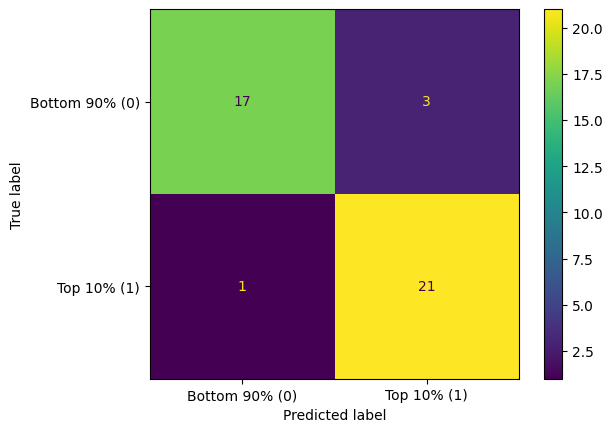

AUC: 0.955


In [31]:
# Metrics

print(f"Accuracy: {accuracy_score(y_test_res, y_pred_us)}")
print(f"Precision: {precision_score(y_test_res, y_pred_us)}")
print(f"Recall: {recall_score(y_test_res, y_pred_us)}")

cm_us = confusion_matrix(y_test_res, y_pred_us)
disp_us = ConfusionMatrixDisplay(confusion_matrix=cm_us, display_labels=['Bottom 90% (0)', 'Top 10% (1)'])

disp_us.plot()
plt.show()

fpr_us, tpr_us, threshold_us = roc_curve(y_test_res, y_proba_us)
roc_auc_us = auc(fpr_us, tpr_us)
print(f"AUC: {roc_auc_us:.3f}")

### OverSampling (RandomOverSampler)

In [32]:
# Oversampling

ros = RandomOverSampler(sampling_strategy=1)
X_os, y_os = ros.fit_resample(X, y2)

print(y_os.value_counts())

top_math
0    897
1    897
Name: count, dtype: int64


In [33]:
# Split and train the oversampled data

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.2, random_state=42)

lr_oversampled = LogisticRegression()
lr_oversampled.fit(X_train_os, y_train_os)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [34]:
# Predict probabilities

y_pred_os = lr_oversampled.predict(X_test_os)
y_proba_os = lr_oversampled.predict_proba(X_test_os)[:, 1]

Accuracy: 0.9080779944289693
Precision: 0.8804347826086957
Recall: 0.9364161849710982


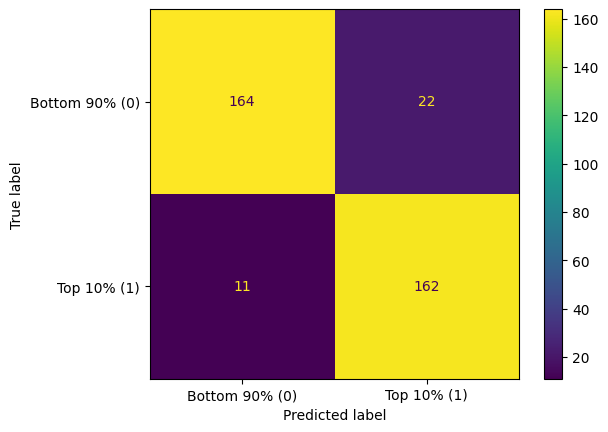

AUC: 0.969


In [35]:
# Metrics

print(f"Accuracy: {accuracy_score(y_test_os, y_pred_os)}")
print(f"Precision: {precision_score(y_test_os, y_pred_os)}")
print(f"Recall: {recall_score(y_test_os, y_pred_os)}")

cm_os = confusion_matrix(y_test_os, y_pred_os)
disp_os = ConfusionMatrixDisplay(confusion_matrix=cm_os, display_labels=['Bottom 90% (0)', 'Top 10% (1)'])

disp_os.plot()
plt.show()

fpr_os, tpr_os, threshold_os = roc_curve(y_test_os, y_proba_os)
roc_auc_os = auc(fpr_os, tpr_os)
print(f"AUC: {roc_auc_os:.3f}")

In [36]:
# Class Weighting

# use the X_train top, X_test_top, y_train_top, y_test top corresponding to top_math
# fit the model

lr_weighted = LogisticRegression(class_weight='balanced')
lr_weighted.fit(X_train_top, y_train_top)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [37]:
# Predict

y_pred_w = lr_weighted.predict(X_test_top)
y_proba_w = lr_weighted.predict_proba(X_test_top)[:, 1]

Accuracy: 0.845
Precision: 0.275
Recall: 0.8461538461538461


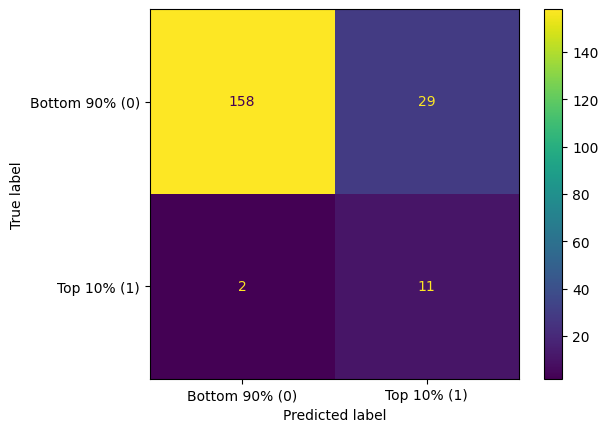

AUC: 0.938


In [38]:
print(f"Accuracy: {accuracy_score(y_test_top, y_pred_w)}")
print(f"Precision: {precision_score(y_test_top, y_pred_w)}")
print(f"Recall: {recall_score(y_test_top, y_pred_w)}")

cm_w = confusion_matrix(y_test_top, y_pred_w)
disp_w = ConfusionMatrixDisplay(confusion_matrix=cm_w, display_labels=['Bottom 90% (0)', 'Top 10% (1)'])
disp_w.plot()
plt.show()

fpr_w, tpr_w, threshold_w = roc_curve(y_test_top, y_proba_w)
roc_auc_w = auc(fpr_w, tpr_w)
print(f"AUC: {roc_auc_w:.3f}")

### Imbalanced Classification Results

***Undersampling***
- Accuracy: 0.905
- Precision: 0.909
- Recall: 0.909
- AUC: 0.989

***Oversampling***
- Accuracy: 0.919
- Precision: 0.883
- Recall: 0.96
- AUC: 0.966

***Class Weighting***
- Accuracy: 0.845
- Precision: 0.275
- Recall: 0.846
- AUC: 0.938

*Conclusion*
- Oversampling seems to be the overall winner
- Undersampling is good but worse than oversampling
- Baseline is misleading (looks good but bad recall)
- Class weighting helps but ruins precision

***Plot Probability Distributions***

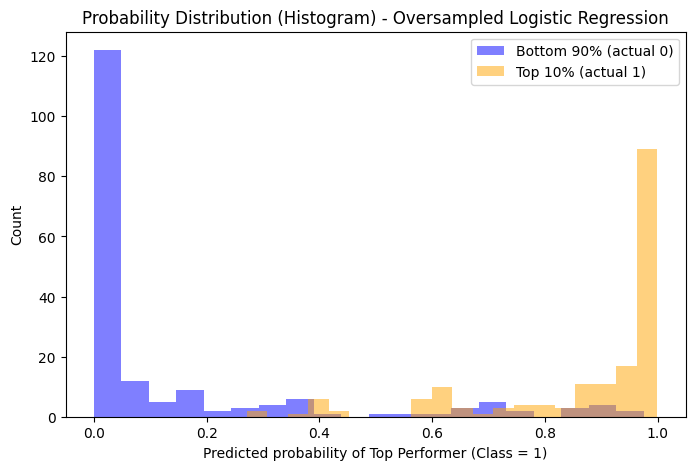

C:\Users\keele\AppData\Local\Temp\ipykernel_17720\3705253873.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs_not, label="Bottom 90% (actual 0)", shade=True)
C:\Users\keele\AppData\Local\Temp\ipykernel_17720\3705253873.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probs_top, label = "Top 10% (actual 1)", shade = True)


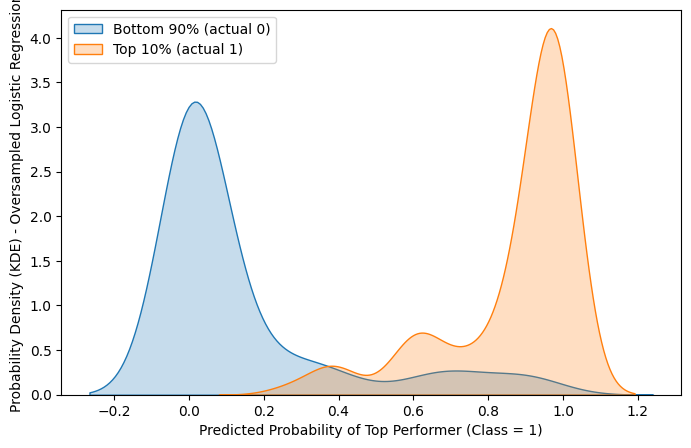

In [40]:
# Overlaid Histograms

probs_top = y_proba_os[y_test_os == 1] # actual top 10%
probs_not = y_proba_os[y_test_os == 0] # actual bottom 90%

plt.figure(figsize=(8,5))

# histogtrams
plt.hist(probs_not, bins=20, alpha=0.5, label="Bottom 90% (actual 0)", color="blue") # blue bars represent bottom 90%
plt.hist(probs_top, bins=20, alpha=0.5, label="Top 10% (actual 1)", color="orange") # orange bars represent top 10%

plt.xlabel("Predicted probability of Top Performer (Class = 1)")
plt.ylabel("Count")
plt.title("Probability Distribution (Histogram) - Oversampled Logistic Regression")
plt.legend()
plt.show()

# kde curves
plt.figure(figsize=(8,5))
sns.kdeplot(probs_not, label="Bottom 90% (actual 0)", shade=True)
sns.kdeplot(probs_top, label = "Top 10% (actual 1)", shade = True)

plt.xlabel("Predicted Probability of Top Performer (Class = 1)")
plt.ylabel("Probability Density (KDE) - Oversampled Logistic Regression")
plt.legend()
plt.show()

- The histogram shows the predicted probabilities of being a top performer (class = 1)
    - Blue bars = actual bottom 90% (class 0)
    - Orange bars = actual top 10% (class 1)

- The kde plot shows the shape of the distribution
    - Peaks around 0.0 (slightly more)
    - Declines quickly as probability decreases
    - Almost no blue density near 1.0

The oversampled model learned very strong signals to differentiate top performers. It became confident because oversampling fixed the data imbalance. Logistic regression is now producing probabilities close to 0 or 1 which is great for a well-trained classifier on balanced data.

### ***Takeways***
Histogram takeaway:
- The oversampled model produces very distinct probability distributions for top performers vs non–top performers. Class 0 predictions cluster near 0, while class 1 predictions cluster near 1, showing strong separation.

KDE takeaway:
- The KDE plot shows two clearly separated peaks, confirming that oversampling allowed the model to learn a much clearer decision boundary compared to the baseline model.

Real-world meaning:
- If this were a real student-performance system, the model could reliably flag top performers with high confidence and few false alarms.

## Summary

- Logistic Regression is the best model for predicting math pass/fail,
  with the highest AUC and strong precision/recall.
- For the rare `top_math` target, the original imbalanced model looks good
  on accuracy but has poor recall for top performers.
- Undersampling and oversampling both improve rare-class performance.
  Oversampling provides the best overall trade-off between recall,
  precision, and AUC.
- Class weighting improves recall but at the cost of much lower precision.
- Probability-distribution plots show that the oversampled logistic model
  cleanly separates top performers from the rest, which matches the high AUC.